In [7]:
import json
import os
import pathlib
import time
import geopandas as gpd
import pandas as pd

import requests
from requests.auth import HTTPBasicAuth
from planet import Session, DataClient, OrdersClient, Auth, Planet

crs = "EPSG:4326"
county_filepath = "/capstone/wildfire_prep/data/ca_counties/CA_Counties.shp"
sb_bbox = [-125, 34.25, -119.0, 38.0]

data_api_url = "https://api.planet.com/data/v1"
stats_url = "{}/stats".format(data_api_url)

counties = (
    gpd
    .read_file(county_filepath)
    .to_crs(crs)
    )

sb_county = (
    counties
    .loc[counties["NAME"] == "Santa Barbara"]
    .clip(sb_bbox)
    )

Set api key and authorize

In [8]:
# if your Planet API Key is not set as an environment variable, you can paste it below
if os.environ.get('PL_API_KEY') == None:
    os.environ["PL_API_KEY"] = 'PLAK723f32b266fa484cb256071a3006e80b'
    
planet_key = os.environ.get("PL_API_KEY")

# Setup the session
session = requests.Session()

# Authenticate
session.auth = (planet_key, "")

res = session.get(data_api_url)
print(res.status_code)

# helper function to print formatted json
def p(data):
    print(json.dumps(data, indent = 2))



200


In [9]:
print(planet_key)
print(Planet())

PLAK723f32b266fa484cb256071a3006e80b


test polygon

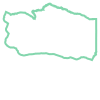

In [10]:
sb_county.boundary.iloc[0]

get geojson

In [11]:
sb_json = (
    dict( # convert to dict because first index outputs as list
        sb_county
        .to_geo_dict() # convert polygon to geojson format
        ["features"][0] # select first and only feature
        )
        ["geometry"] # select geometry attribute
    )

sb_json

{'type': 'Polygon',
 'coordinates': (((-120.73430466331337, 34.900693798243516),
   (-120.73431466335911, 34.9007827989168),
   (-120.73439466282672, 34.90150379865496),
   (-120.73433966347348, 34.90475579881121),
   (-120.73342966470078, 34.910165798505375),
   (-120.7319616639146, 34.91430779965147),
   (-120.73020066412381, 34.91808579979871),
   (-120.72883866454116, 34.921388800583415),
   (-120.72724266460678, 34.92332080112871),
   (-120.72777666453416, 34.92542580113632),
   (-120.72834366497183, 34.92824280064568),
   (-120.72836866508618, 34.928368801229965),
   (-120.72851866577234, 34.93165180168346),
   (-120.7285096655515, 34.93194980158114),
   (-120.72842266641118, 34.93493880145802),
   (-120.7281226659372, 34.938261802295706),
   (-120.72741466593256, 34.941588802547535),
   (-120.7267656654791, 34.94380980277702),
   (-120.7257576658988, 34.94650480349283),
   (-120.72426866699288, 34.94967580341281),
   (-120.72221366657588, 34.95315480396105),
   (-120.72027466561

Set filters

In [12]:
# set geometry filter
geometry_filter = {
    "type": "GeometryFilter", 
    "field_name": "geometry", 
    "config": sb_json
}

# set date filter
date_range_filter = {
    "type": "DateRangeFilter", 
    "field_name": "acquired",  
    "config": { 
        "gte": "2018-01-01T00:00:00.000Z",
        "lt":  "2024-01-01T00:00:00.000Z"
    }
}

# set cloud cover filter
cloud_cover_filter = {
    "type": "RangeFilter", 
    "field_name": "cloud_cover", 
    "config": {
        "lt": 0.5
    }
}

# combine filters
combined_filters = {
    "type": "AndFilter", 
    "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}

In [13]:
item_types = ["PSScene"]

search_request = {
    "item_types": item_types, 
    "interval": "year", 
    "filter": combined_filters
}

search_result = session.post(stats_url, json=search_request)

p(search_result.json())


{
  "buckets": [
    {
      "count": 15441,
      "start_time": "2018-01-01T00:00:00.000000Z"
    },
    {
      "count": 14428,
      "start_time": "2019-01-01T00:00:00.000000Z"
    },
    {
      "count": 15828,
      "start_time": "2020-01-01T00:00:00.000000Z"
    },
    {
      "count": 13888,
      "start_time": "2021-01-01T00:00:00.000000Z"
    },
    {
      "count": 7671,
      "start_time": "2022-01-01T00:00:00.000000Z"
    },
    {
      "count": 5499,
      "start_time": "2023-01-01T00:00:00.000000Z"
    }
  ],
  "interval": "year",
  "utc_offset": "+0h"
}
